# Language in Focus, Part 1: Predicting Movie Magic
# Introduction
Natural Language Processing (NLP) is a current topic in machine learning (ML). With the commercialisation of Chat GPT [3] and the integration of chatbots into business environments [4], NLP has become a part of our everyday lives. Before Generative Pre-trained Transformers (GPTs), a turning point in the field of NLP was the development of Recursive Neural Networks (RNNs). Researchers developed RNNs to better model the dependencies in sequential data [2]. Interpreting and predicting sequences of words was essential to the success of NLP.
This blog post will introduce how researchers approach NLP, exploring the most common data processing and classification methods. Next, it will cover RNNs in-depth, including memory cells, the back-propagation through time (BPTT) algorithm and the challenges RNNs face. Lastly, we will illustrate how we can use NLP to classify film genres by summarising one of WDSS’s own research projects!

# Introduction to NLP

Data processing is a crucial stage in any ML project. As NLP is a well-established field, many tricks for processing and normalising text data exist:
- Non-linguistic analysis is used on social media platforms where users write posts containing icons, special characters, platform-specific prefixes and web links. This preprocessing method involves removing characters, assigning values to represent non-text features, and removing images and links[1].
  
- Morphological analysis [1] is another method for text data processing. It includes tokenisation, where researchers use a dictionary to convert each word into a unique integer, removing punctuation and removing “stop words'' such as the, is, a, and and in English.
  
- Syntactic analysis is a text data processing method where researchers tag words as a “part of speech”. These would be nouns, verbs, articles, adjectives and more.
  
- Lastly, semantic analysis focuses on the meaning of words. This method uses emotion dictionaries to index the emotions associated with words.
  
Once the text data is processed, it can be classified. ML algorithms like Support Vector Machines (SVM), Naive Bayes and Decision Trees can all solve language classification tasks. However, deep neural networks have become more common due to their better performance in multi-class classification [7]. These neural networks include Convolutional Neural Networks (CNNs) [5] and RNNs [6].


# What are Recurrent Neural Networks?

An RNN is a neural network with an internal state that stores previous inputs [2]. RNNs model the dependencies in sequential data, which is necessary for NLP as often words need to be understood in the context of a sentence or wider text. This is best illustrated by a diagram.


Neurons with recurrence [8].

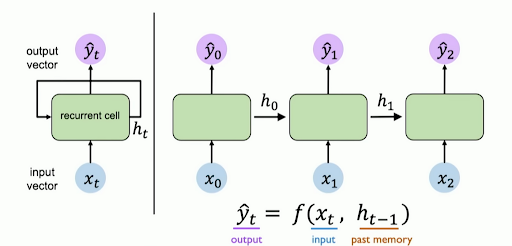

Each recurrent cell represents a discrete time step. At each time step, the cell has weights that map the input vector x_t to an output vector y_t. These weights are shared between cells through the hidden states h_t. The recurrent network creates a summary of previous observations via these connections. In this way, the network “remembers” relationships between events over time in the data [2]. A recurrence relation updates the hidden state h_t at each time step. This relation is defined by a function f_h of the input x_t to that cell at that time and the previous state h_t-1 of the cell.

The recurrence relation [2].

$h_{t} = f_{h}(X_{t}, h_{t-1})$

An activation function is a nonlinear function that defines the output of a neuron in a network. Here, f_h represents the activation function tanh. Therefore, the complete formula for calculating the hidden state is:

Formula for calculating the hidden state [2].

$h_{t} = tanh(X_{t}W_{xh} + h_{t-1}W_{hh} + b_{h})$

The output of a single recurrent neuron is a function of the hidden state.

Output of a single recurrent neuron [2].

$\tilde{y_{t}} = f_{0}(h_{t})$

Specifically, the hidden state is weighted and biased to set how harshly the network should apply these weights during training. Next, the result o_t is passed through another activation function: Softmax.

The hidden state is weighted and biased and the result is passed through the Softmax function [2].

$o_{t} = h_{t}W_{hy} + b_{y}$

$\tilde{y_{t}} = softmax(o_{t}))$

RNNs train by an algorithm called backpropagation through time (BPTT). Backpropagation takes the derivative with respect to each parameter (called the “loss”) and shifts parameters to minimise loss [2]. The BPTT algorithm backpropagates the loss for each of the individual time steps, from the current time to the initial time in the sequence. This means that the gradient is computed repeatedly, which can cause problems. The two most common issues that this causes are the vanishing and exploding gradient problems. In short, gradients “explode” when the weight matrices are large. This prevents the network from converging at a stable predicted value. Similarly, gradients vanish when the weights are small. This prevents the network from using all the important information when training, leading to incorrect predictions. Exploding gradients can be prevented using a method called gradient clipping. Vanishing gradients can be mitigated by using the rectified linear unit (ReLU) activation function, or by using gated cells. These cells selectively control the flow into the neural network, filtering out what is not important [8]. Long Short Term Memory cells (LSTMs) and Gated Recurrent Units (GRUs) are common types of gated cells.

# An example: Movie Genre Classification

One common application of NLP is grouping entertainment media, such as movies or blog posts, into categories for users to choose from. This type of problem requires a many-to-one RNN. The image below shows an example of a many-to-one RNN for classifying the sentiment (emotional positivity or negativity) of a sentence.

Many-to-one RNN [8].

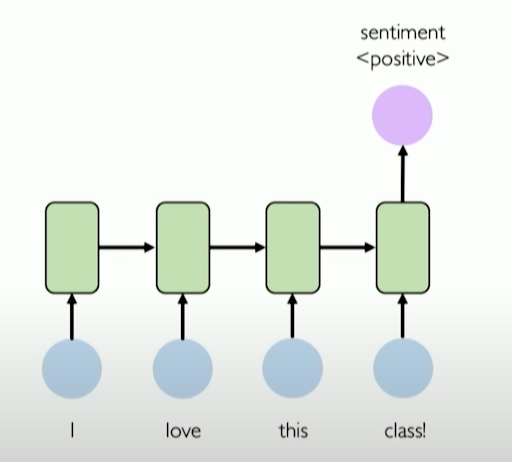

We completed a research project with the aim to classify movies into their respective genres based on their IMDb descriptions using an RNN. First, we analysed the data to identify the uneven frequencies of genre classes. We then processed the data using the NLTK python library and split the training and testing datasets. 

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import nltk
import pickle
import seaborn as sns
from sklearn.model_selection import train_test_split
device = torch.device('cuda')

import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

def clean(text):
    stop_words = stopwords.words('english')
    text = text.replace('-',' ')
    translator = str.maketrans('','',string.punctuation + string.digits)
    n_text = text.translate(translator)
    words = word_tokenize(n_text)
    filtered_words = [word for word in words if word not in stop_words]
    return filtered_words

wint_dict = {}
def words_int(words):
    for word in words:
        if word not in wint_dict:
            wint_dict[word] = len(wint_dict) + 1
    int_list = [wint_dict[word] for word in words]
    return int_list

gint_dict = {}
def to_int(word):
    if word not in gint_dict:
        gint_dict[word] = len(gint_dict)+1
    return gint_dict[word]

train_data = pd.read_csv('train_data.txt', sep = ':::', header = None, engine = 'python')
train_data.columns = ['id','title','genre','description']
train_selection = train_data[['genre','description']]
train_np = train_selection.values

lengths = []
descriptions = np.array(np.zeros(200))
genres = np.array(np.zeros(1))
for row in train_np:
    row[1] = row[1].lower()
    row[1] = clean(row[1])
    row[1] = np.array(words_int(row[1]))
    lengths.append(len(row[1]))
    row[1] = row[1][:200]
    row[0] = np.array(to_int(row[0]))
    npad = 200 - len(row[1])
    row[1] = np.pad(row[1],npad)[npad:]
    descriptions = np.vstack([descriptions,row[1]])
    genres = np.vstack([genres,row[0]])
descriptions = descriptions[1:]
genres = genres[1:]

In [ ]:
hidden_size = 128
num_classes = 28
num_epochs = 6
batch_size = 200
learning_rate = 0.001
input_size = 1
sequence_length = 200
num_layers = 3

descriptions = np.load('descriptions_np.npy')
genres_arrs = np.load('genres_np.npy')
genres = genres_arrs.ravel()

with open('descriptions_dict.pkl','rb') as d:
    descriptions_dict = pickle.load(d)

with open('genres_dict.pkl','rb') as g:
    genres_dict = pickle.load(g)

def reverse_g(n):
    return([val for val in genres_dict if genres_dict[val] == int(n)])[0]

descriptions_t = torch.tensor(descriptions)
full_data = []
for i in range(len(descriptions_t)):
    full_data.append((descriptions_t[i].float(),int(genres_arrs[i][0])))

data_restricted = [row for row in full_data if row[1] in [1,4,5]]

In [ ]:
plt.figure(figsize=(12,8))
#plt.hist(genres,bins = 27, edgecolor = 'black',orientation='horizontal')
#for i in range(1,28):
    #plt.text(0,i,reverse_g(i))
#unique_values = np.unique(genres)
#genres_df = pd.DataFrame(genres)
#genres_df.value_counts().plot.barh()
genres_unique, genre_counts = np.unique(genres, return_counts=True)
labels = [reverse_g(g) for g in genres_unique]
plt.barh(labels,genre_counts)
plt.xlabel('Frequency')
plt.title('Frequencies of the different genres')

In [ ]:
train_slice, test_slice = train_test_split(full_data, test_size=0.2)
#class MyDataset(torch.utils.data.Dataset):
    #def __init__(self, my_array):
        #self.my_array = my_array
    #def __len__(self):
        #return len(self.my_array)
    #def __getitem__(self, index):
        #return self.my_array[index]

train_loader = torch.utils.data.DataLoader(dataset = train_slice, batch_size = batch_size, shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_slice, batch_size = batch_size, shuffle = True)


Analysis of the class imbalance.

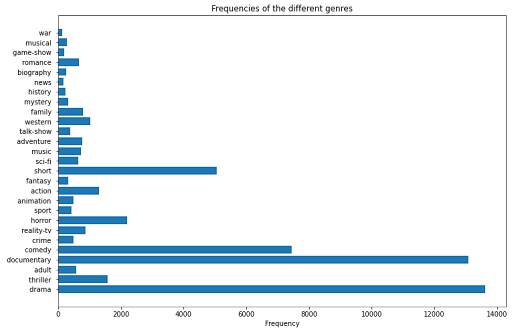

Next, we set up the learning frameworks using the ML library PyTorch. This included building an RNN class and addressing the vanishing gradients problem with an LSTM class and a GRU class. 

In [ ]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNN, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first = True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self,x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)

        out, _ = self.rnn(x,h0)
        out = out[:, -1, :]
        out = self.fc(out)

        return out

class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(GRU, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first = True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self,x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)

        out, _ = self.gru(x,h0)
        out = out[:, -1, :]
        out = self.fc(out)

        return out

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTM, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first = True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self,x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)


        out, _ = self.lstm(x,(h0,c0))
        out = out[:, -1, :]
        out = self.fc(out)

        return out

Then, we built a function to train the model, using the cross entropy loss function and the Adam optimiser.

In [ ]:
#Train the model
#loss and optimiser

def run(model,train_loader,test_loader):
    losses = []
    criterion = nn.CrossEntropyLoss()
    optimiser = torch.optim.Adam(model.parameters(),lr = learning_rate)


    n_total_steps = len(train_loader)

    for epoch in range(num_epochs):
        for i, (descriptions_l, genres_l) in enumerate(train_loader):
            descriptions_l = descriptions_l.reshape(-1, sequence_length, input_size).to(device)
            genres_l = genres_l.to(device)
            genres_l = genres_l.long()

            outputs = model(descriptions_l)
            loss = criterion(outputs, genres_l)

            optimiser.zero_grad()
            loss.backward()
            optimiser.step()

            if (i+1) % 200 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')
                losses.append(loss.item())

    with torch.no_grad():
        n_correct = 0
        n_samples = 0
        corrects = np.zeros(28)
        totals = np.zeros(28)
        guesses = np.zeros(28)
        for descriptions_l, genres_l in test_loader:
            descriptions_l = descriptions_l.reshape(-1,sequence_length, input_size).to(device)
            genres_l = genres_l.to(device)
            outputs = model(descriptions_l)

            _, predicted = torch.max(outputs.data, -1)
            n_samples += genres_l.size(0)
            elements_equal = (predicted == genres_l)
            n_correct += elements_equal.sum().item()
            for i in range(28):
                i_tensor = torch.tensor(np.full(len(genres_l),i), device = device)
                corrects[i]+= (elements_equal * (genres_l == i_tensor)).sum().item()
                totals[i] += (genres_l == i_tensor).sum().item()
                guesses[i] += (predicted == i_tensor).sum().item()
        acc = 100.0*n_correct/n_samples
        accuracies = np.divide(corrects[1:],totals[1:])
        print(f'Accuracy of the network on the test descriptions:{acc}%')
        #print(totals)
        #print(guesses)
        #print(accuracies)
        #plt.bar(range(27),totals[1:])
        #plt.show()
        plt.barh(labels,guesses[1:])
        plt.xlabel('Number of guesses')
        plt.title('Guesses for the different genres by the model')

        plt.show()
        plt.barh(labels,accuracies)
        plt.xlabel('Percentage accuracy')
        plt.title('Accuracies for the different genres')
        #plt.plot(losses)

Lastly, we evaluated the model’s accuracy and found that the unbalanced dataset meant that the model could classify dramas and documentaries well but not other genres.

In [ ]:
run(RNN(input_size, hidden_size, num_layers, num_classes).to(device),train_loader,test_loader)

In [ ]:
run(GRU(input_size, hidden_size, num_layers, num_classes).to(device),train_loader,test_loader)

In [ ]:
run(LSTM(input_size, hidden_size, num_layers, num_classes).to(device),train_loader,test_loader)

RNN with GRUs model accuracy.

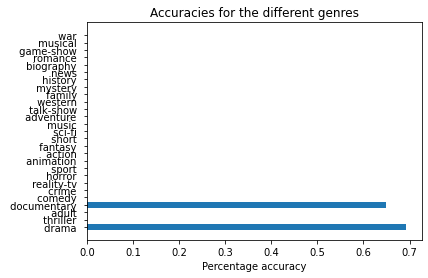

This shows that finding a good dataset is important!

# Next Steps

The research project covered in this blog used the PyTorch library: an ML framework developed by Meta AI. You can find tutorials on this library in your own projects [here](https://pytorch.org/tutorials/). [Python Natural Language Toolkit (NLTK)](https://www.nltk.org/) is another great resource for language processing. It provides language datasets, libraries for text data processing, guides and documentation. Lastly, serverless data processing is essential when working with real-time text data, such as social media feeds or chat forums. Amazon Web Services has a [tutorial on serverless data processing](https://aws.amazon.com/getting-started/projects/build-serverless-real-time-data-processing-app-lambda-kinesis-s3-dynamodb-cognito-athena/5/) that you could adapt to advance your NLP skills!

# References
1. D. Rogers, A. Preece, M. Innes and I. Spasić, “Real-Time Text Classification of User-Generated Content on Social Media: Systematic Review,” in IEEE Transactions on Computational Social Systems, vol. 9, no. 4, pp. 1154–1166, Aug. 2022, doi: 10.1109/TCSS.2021.3120138.
   
2. Mohamed Abdel-Basset; Nour Moustafa; Hossam Hawash, “Introducing Recurrent Neural Networks,” in Deep Learning Approaches for Security Threats in IoT Environments, IEEE, 2023, pp.189–207, doi: 10.1002/9781119884170.ch8.
   
3. T. Wu et al., “A Brief Overview of ChatGPT: The History, Status Quo and Potential Future Development,” in IEEE/CAA Journal of Automatica Sinica, vol. 10, no. 5, pp. 1122–1136, May 2023, doi: 10.1109/JAS.2023.123618.
   
4. M. Banisharif, A. Mazloumzadeh, M. Sharbaf and B. Zamani, “Automatic Generation of Business Intelligence Chatbot for Organizations,” 2022 27th International Computer Conference, Computer Society of Iran (CSICC), Tehran, Iran, Islamic Republic of, 2022, pp. 1–5, doi: 10.1109/CSICC55295.2022.9780490.
   
5. Y. LeCun, L. Bottou, Y. Bengio and P. Haffner, “Gradient-based learning applied to document recognition”, Proc. IEEE, vol. 86, no. 11, pp. 2278–2324, Nov. 1998.
   
6. R. J. Williams and D. Zipser, “A learning algorithm for continually running fully recurrent neural networks”, Neural Comput., vol. 1, no. 2, pp. 270–280, 1989.
   
7. H. A. Sayyed, S. Rushikesh Sugave, S. Paygude and B. N Jazdale, “Study and Analysis of Emotion Classification on Textual Data,” 2021 6th International Conference on Communication and Electronics Systems (ICCES), Coimbatre, India, 2021, pp. 1128–1132, doi: 10.1109/ICCES51350.2021.9489204.
   
8. Alexander Amini and Ava Amini, “MIT 6.S191: Introduction to Deep Learning”, Accessible at: IntroToDeepLearning.com